In [1]:
# # Necessary imports
import torch
# from torch import nn
# import torch.nn.functional as F
# import torchvision
# from torchvision import transforms
# from torchinfo import summary
# from tqdm import tqdm
# from torch.utils.data import Dataset, DataLoader
# import os
# import pandas as pd
# import cv2
# from PIL import Image
# from sklearn.model_selection import train_test_split

In [2]:
# For reproducibility
# torch.manual_seed(0)
# torch.backends.cudnn.benchmark = True

In [3]:
print(torch.cuda.device_count())
print(torch.cuda.is_available())

1
True


In [4]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F

import random
import os, shutil
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import segmentation_models_pytorch as smp

%matplotlib inline

In [5]:
import os
root_dir = '/home/yasaisen/Desktop/10_research/research_main/lab_01'

In [6]:
class Config:
    
    data_dir = os.path.join(root_dir, "kaggle_3m/")
    
    validation_fraction = 0.15
    test_fraction = 0.10
    train_batch = 16
    valid_batch = 32
    test_batch = 32
    
    input_dim = 256
    input_ch = 3
    output_dim = 256
    output_ch = 1
    
    seed = 1
    learning_rate = 0.01
    epochs = 30
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def plot_example(idx):
    base_path = Config.data_dir+ test_df['directory'].iloc[idx]
    img_path = os.path.join(base_path, test_df['images'].iloc[idx])
    mask_path = os.path.join(base_path, test_df['masks'].iloc[idx])
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    print(np.max(np.asarray(mask)))
    
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].imshow(img)
    ax[0].set_title("Image")
    ax[1].imshow(mask)
    ax[1].set_title("Mask")
    plt.show()

In [8]:
def show_sample(sample, title=None):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(sample[0])
    ax[1].imshow(sample[1], cmap="gray")
    if title:
        fig.suptitle(title)
    plt.show()

In [9]:
def plot_predictions(model, idx):
    base_path = os.path.join(Config.data_dir, test_df['directory'].iloc[idx])
    img_path = os.path.join(base_path, test_df['images'].iloc[idx])
    mask_path = os.path.join(base_path, test_df['masks'].iloc[idx])
    
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    
    tensor_img, tensor_mask = eval_transforms((img, mask))
    tensor_img = tensor_img.unsqueeze(0).to(Config.device)
    
    model.eval()
    
    with torch.no_grad():
        pred = model(tensor_img)[0].detach().cpu().numpy()
        pred = pred.transpose((1,2,0)).squeeze()
        rounded = np.round(pred)
        
    plot_images = {
        'Image': img,
        'Mask': mask,
        'Predicted Mask': pred,
        'Predicted Rounded Mask':rounded
    }
    
    fig, ax = plt.subplots(1, 4, figsize=(16,4))
    for i, key in enumerate(plot_images.keys()):
        ax[i].imshow(plot_images[key])
        ax[i].set_title(key)
        
    plt.show()

In [10]:
set_seed(Config.seed)

In [11]:
dirs, images, masks = [], [], []

i =0

for root, folders, files in  os.walk(Config.data_dir):
    for file in files:
        if 'mask' in file:
            dirs.append(root.replace(Config.data_dir, ''))
            masks.append(file)
            images.append(file.replace("_mask", ""))

PathDF = pd.DataFrame({'directory': dirs,
                      'images': images,
                      'masks': masks})
PathDF.head()

,directory,images,masks
0,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_16.tif,TCGA_HT_7690_19960312_16_mask.tif
1,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_10.tif,TCGA_HT_7690_19960312_10_mask.tif
2,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_18.tif,TCGA_HT_7690_19960312_18_mask.tif
3,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_17.tif,TCGA_HT_7690_19960312_17_mask.tif
4,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_9.tif,TCGA_HT_7690_19960312_9_mask.tif


In [12]:
for i in PathDF.index:
    PathDF.loc[i, "diagnosis"] = 1 if np.max(cv2.imread(os.path.join(Config.data_dir, PathDF.loc[i, 'directory'], PathDF.loc[i,"masks"]))) > 0 else 0

In [13]:
PathDF.head()

,directory,images,masks,diagnosis
0,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_16.tif,TCGA_HT_7690_19960312_16_mask.tif,1.0
1,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_10.tif,TCGA_HT_7690_19960312_10_mask.tif,0.0
2,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_18.tif,TCGA_HT_7690_19960312_18_mask.tif,1.0
3,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_17.tif,TCGA_HT_7690_19960312_17_mask.tif,1.0
4,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_9.tif,TCGA_HT_7690_19960312_9_mask.tif,0.0


In [14]:
PathDF['diagnosis'].value_counts()

0.0    2556
1.0    1373
Name: diagnosis, dtype: int64

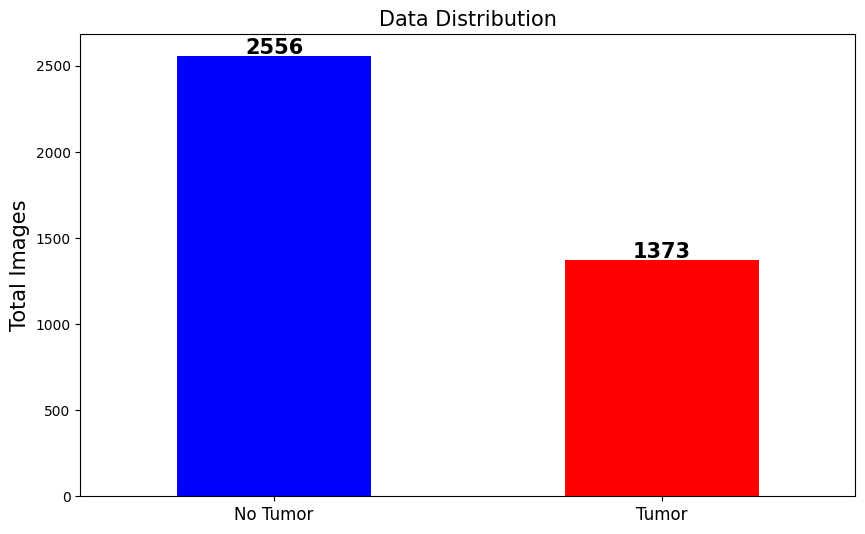

In [15]:
ax = PathDF['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(PathDF['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

In [16]:
train2rest = Config.validation_fraction + Config.test_fraction
test2valid = Config.validation_fraction / train2rest

train_df, rest = train_test_split(PathDF, random_state=Config.seed,
                                 test_size = train2rest)

test_df, valid_df = train_test_split(rest, random_state=Config.seed,
                                    test_size = test2valid)

print('Train:', train_df.shape[0])
print('Valid:', valid_df.shape[0])
print('Test:', test_df.shape[0])

Train: 2946
Valid: 590
Test: 393


In [17]:
class MRI_Dataset(Dataset):
    def __init__(self, path_df, transform=None):
        self.path_df = path_df
        self.transform = transform
        
    def __len__(self):
        return self.path_df.shape[0]
    
    def __getitem__(self, idx):
        
        base_path = os.path.join(Config.data_dir, self.path_df.iloc[idx]['directory'])
        img_path = os.path.join(base_path, self.path_df.iloc[idx]['images'])
        mask_path = os.path.join(base_path, self.path_df.iloc[idx]['masks'])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        sample = (image, mask)
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample   

In [18]:
class PairedRandomHorizontalFlip():
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, sample):
        img, mask = sample
        if np.random.random() < self.p:
            img, mask = TF.hflip(img), TF.hflip(mask)
            
        return img, mask

In [19]:
class PairedRandomAffine():
    def __init__(self, degrees= None, translate=None, scale_ranges=None,
                shears=None):
        self.params = {
            'degree': degrees,
            'translate': translate,
            'scale_ranges':scale_ranges,
            'shears':shears
        }
    def __call__(self, sample):
        img, mask = sample
        w, h = img.size
        
        angle, translations, scale, shear = transforms.RandomAffine.get_params(
            self.params['degree'], self.params['translate'],
            self.params['scale_ranges'], self.params['shears'],
            (w,h)
        )
        
        img = TF.affine(img, angle, translations, scale, shear)
        mask = TF.affine(mask, angle, translations, scale, shear)
        
        return img, mask

In [20]:
class PairedToTensor():
    def __call__(self, sample):
        img, mask = sample
        img = np.array(img)
        mask = np.expand_dims(mask, -1)
        img = np.moveaxis(img, -1, 0)
        mask = np.moveaxis(mask, -1, 0)
        img, mask = torch.FloatTensor(img), torch.FloatTensor(mask)
        img = img/255
        mask = mask/255
        return img, mask
dataset = MRI_Dataset(test_df)
sample = dataset[59]
transform = PairedRandomHorizontalFlip(p=1)
transform = PairedRandomAffine(
    degrees = (15,15),
    scale_ranges = (1.2, 1.2)
)

In [21]:
train_transforms = transforms.Compose(
    [PairedRandomHorizontalFlip(),
    PairedRandomAffine(
        degrees=(-15, 15),
        translate=(0.1, 0.1),
        scale_ranges=(0.8, 1.2)
    ),
    PairedToTensor()
    ])

eval_transforms = PairedToTensor()

train_data = MRI_Dataset(train_df, transform=train_transforms)
valid_data = MRI_Dataset(valid_df, transform=eval_transforms)
test_data = MRI_Dataset(test_df, transform=eval_transforms)

train_loader = DataLoader(train_data, batch_size=Config.train_batch,
                         shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=Config.valid_batch,
                         shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=Config.test_batch,
                        shuffle=False, num_workers=2)

In [22]:
model = smp.Unet(    
    in_channels=Config.input_ch,                  
    classes=Config.output_ch,
    activation="sigmoid").to(Config.device)


In [23]:
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

/tmp/ipykernel_42140/561252387.py:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  img, mask = torch.FloatTensor(img), torch.FloatTensor(mask)
/tmp/ipykernel_42140/561252387.py:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  img, mask = torch.FloatTensor(im

torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])


In [26]:

# print(model)
t = torch.randn((16, 3, 256, 256)).cuda()
print(t.shape)
get = model(t)
print(get.shape)

torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])


In [27]:
def check_accuracy(loader, model, device):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            _, y = y.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return (num_correct/num_samples).item()
  

def train(epochs, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.BCELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


    for epoch in range(epochs):
        model.train()
        losses = []

        pbar = tqdm(train_loader, total=len(train_loader), position=0, leave=True, desc=f"Epoch {epoch}")
        for data, targets in pbar:
            data = data.to(device)
            targets = targets.to(device)

            # forward
            scores = model(data)
            loss = criterion(scores, targets)
            losses.append(loss.item() * data.shape[0])
            # backward
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
        
        avg_loss = sum(losses) / len(losses)
        acc = check_accuracy(test_loader, model, device)
        print(f"Loss:{avg_loss:.8f}\tAccuracy:{acc:.8f}")

    return model

In [28]:
def train_step(
    teacher_model,
    student_model,
    optimizer,
    student_loss_fn,
    divergence_loss_fn,
    temp,
    alpha,
    epoch,
    device
):
    losses = []
    pbar = tqdm(train_loader, total=len(train_loader), position=0, leave=True, desc=f"Epoch {epoch}")
    for data, targets in pbar:
        # Get data to cuda if possible
        data = data.to(device)
        targets = targets.to(device)

        # forward
        with torch.no_grad():
            teacher_preds = teacher_model(data)

        student_preds = student_model(data)
        student_loss = student_loss_fn(student_preds, targets)
        
        ditillation_loss = divergence_loss_fn(
            F.log_softmax(student_preds / temp, dim=1),
            F.softmax(teacher_preds / temp, dim=1)
        )
        loss = alpha * student_loss + (1 - alpha) * ditillation_loss
        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    
    avg_loss = sum(losses) / len(losses)
    return avg_loss
  
def main(epochs, teacher, student, temp=7, alpha=0.3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    teacher = teacher.to(device)
    student = student.to(device)
    student_loss_fn = nn.CrossEntropyLoss()
    divergence_loss_fn = nn.KLDivLoss(reduction="batchmean")
    optimizer = torch.optim.Adam(student.parameters(), lr=1e-4)

    teacher.eval()
    student.train()
    for epoch in range(epochs):
        loss = train_step(
            teacher,
            student,
            optimizer,
            student_loss_fn,
            divergence_loss_fn,
            temp,
            alpha,
            epoch,
            device
        )
        acc = check_accuracy(test_loader, student, device)
        print(f"Loss:{loss:.8f}\tAccuracy:{acc:.8f}")

In [30]:

trained_model = train(3, model)
torch.save({'state_dict': trained_model.state_dict(), 'model' : trained_model,}, os.path.join(ROOT_PATH, 'resnet18.pth'))

Epoch 0:   0%|          | 0/185 [00:00<?, ?it/s]/tmp/ipykernel_42140/561252387.py:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  img, mask = torch.FloatTensor(img), torch.FloatTensor(mask)
/tmp/ipykernel_42140/561252387.py:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_nu

Loss:5.22105756	Accuracy:65536.00000000


Epoch 1:   0%|          | 0/185 [00:00<?, ?it/s]/tmp/ipykernel_42140/561252387.py:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  img, mask = torch.FloatTensor(img), torch.FloatTensor(mask)
/tmp/ipykernel_42140/561252387.py:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_nu

Loss:2.45160787	Accuracy:65536.00000000


Epoch 2:   0%|          | 0/185 [00:00<?, ?it/s]/tmp/ipykernel_42140/561252387.py:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  img, mask = torch.FloatTensor(img), torch.FloatTensor(mask)
/tmp/ipykernel_42140/561252387.py:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_nu

Loss:1.55007862	Accuracy:65536.00000000


NameError: name 'ROOT_PATH' is not defined

In [ ]:
# resnet34_model = resnet34(2)
# trained_resnet34_model = train(3, resnet34_model)
# torch.save({'state_dict': trained_resnet34_model.state_dict(), 'model' : trained_resnet34_model,}, os.path.join(ROOT_PATH, 'resnet34.pth'))

In [ ]:
# trained_resnet18_model = torch.load(os.path.join(ROOT_PATH, 'resnet18.pth'))['model']
# trained_resnet34_model = torch.load(os.path.join(ROOT_PATH, 'resnet34.pth'))['model']

In [ ]:
# # TE=34, ST=18

# trained_resnet34_model = torch.load(os.path.join(ROOT_PATH, 'resnet34.pth'))['model']
# trained_resnet34_model = trained_resnet34_model.cuda()

# student_model = resnet18(2)
# student_model = student_model.cuda()

# main(3, trained_resnet34_model, student_model, alpha=0)

Epoch 0: 100%|██████████| 2343/2343 [01:24<00:00, 27.65it/s]


Loss:0.03518395	Accuracy:0.82119995


Epoch 1: 100%|██████████| 2343/2343 [01:25<00:00, 27.45it/s]


Loss:0.00995989	Accuracy:0.88239998


Epoch 2: 100%|██████████| 2343/2343 [01:26<00:00, 26.94it/s]


Loss:0.00434331	Accuracy:0.89719999


In [ ]:
# # TE=18, ST=34

# trained_resnet18_model = torch.load(os.path.join(ROOT_PATH, 'resnet18.pth'))['model'].cuda()

# student_model = resnet34(2).cuda()
# main(3, trained_resnet18_model, student_model, alpha=0)

Epoch 0: 100%|██████████| 2343/2343 [01:55<00:00, 20.24it/s]


Loss:0.03726752	Accuracy:0.80879998


Epoch 1: 100%|██████████| 2343/2343 [01:55<00:00, 20.22it/s]


Loss:0.01042126	Accuracy:0.88479996


Epoch 2: 100%|██████████| 2343/2343 [01:55<00:00, 20.35it/s]


Loss:0.00555547	Accuracy:0.89800000


In [ ]:
# # TE=34, ST=34

# trained_resnet34_model = torch.load(os.path.join(ROOT_PATH, 'resnet34.pth'))['model'].cuda()

# student_model = resnet34(2).cuda()
# main(3, trained_resnet34_model, student_model, alpha=0)

Epoch 0: 100%|██████████| 2343/2343 [02:07<00:00, 18.43it/s]


Loss:0.03669881	Accuracy:0.82440001


Epoch 1: 100%|██████████| 2343/2343 [02:07<00:00, 18.44it/s]


Loss:0.01010854	Accuracy:0.89879996


Epoch 2: 100%|██████████| 2343/2343 [02:08<00:00, 18.28it/s]


Loss:0.00454724	Accuracy:0.90840000


In [ ]:
# TE=18, ST=18

# trained_resnet18_model = torch.load(os.path.join(ROOT_PATH, 'resnet18.pth'))['model'].cuda()

# student_model = resnet18(2).cuda()
# main(3, trained_resnet18_model, student_model, alpha=0)

Epoch 0: 100%|██████████| 2343/2343 [01:56<00:00, 20.19it/s]


Loss:0.03405485	Accuracy:0.82519996


Epoch 1: 100%|██████████| 2343/2343 [01:16<00:00, 30.68it/s]


Loss:0.00901391	Accuracy:0.88000000


Epoch 2: 100%|██████████| 2343/2343 [02:18<00:00, 16.97it/s]


Loss:0.00451345	Accuracy:0.88999999
